<a href="https://colab.research.google.com/github/Sonali-Kotni57/Deep-Learning-Lab/blob/main/Experiment_6_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experiment-6 LSTM Model**

**Simple LSTM for Sentiment Analysis (on IMDB reviews)**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [3]:
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print("text: ", example.numpy())
  print("label: ", label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.'
 b'"Intensive Care" by Dorna von Rouveroy is easily one of the worst horror movies ever made.This extremely cheap Dutch slasher flick offers some gore and plenty of absurd situations.A horror veteran 

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label:text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,   2, ...,   0,   0,   0],
       [  1, 451,  33, ...,   0,   0,   0],
       [ 99,  18,   8, ...,   0,   0,   0]])

In [11]:
for n in range(3):
  print("original: ", example[n].numpy())
  print("round-trip: ", " ".join(vocab[encoded_example[n]]))

original:  b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.'
round-trip:  [UNK] [UNK] the [UNK] [UNK] [UNK] in a superb [UNK] and [UNK] [UNK] and [UNK] [UNK] give enjoyable performances as they always seem to do br br but come on hollywood a [UNK] [UNK] the p

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
history =model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 380s 954ms/step - loss: 0.6554 - accuracy: 0.5443 - val_loss: 0.5123 - val_accuracy: 0.7375
Epoch 2/5
391/391 [==============================] - 377s 963ms/step - loss: 0.4299 - accuracy: 0.8057 - val_loss: 0.3815 - val_accuracy: 0.8443
Epoch 3/5
391/391 [==============================] - 380s 971ms/step - loss: 0.3485 - accuracy: 0.8502 - val_loss: 0.3440 - val_accuracy: 0.8495
Epoch 4/5
391/391 [==============================] - 378s 965ms/step - loss: 0.3321 - accuracy: 0.8586 - val_loss: 0.3516 - val_accuracy: 0.8495
Epoch 5/5
391/391 [==============================] - 376s 959ms/step - loss: 0.3184 - accuracy: 0.8664 - val_loss: 0.3290 - val_accuracy: 0.8542


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 101,249
Trainable params: 101,249
Non-trainable params: 0
_________________________________________________________________


In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 86s 221ms/step - loss: 0.3208 - accuracy: 0.8582
Test Loss: 0.3208281397819519
Test Accuracy: 0.8581600189208984


In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6722592696547508)

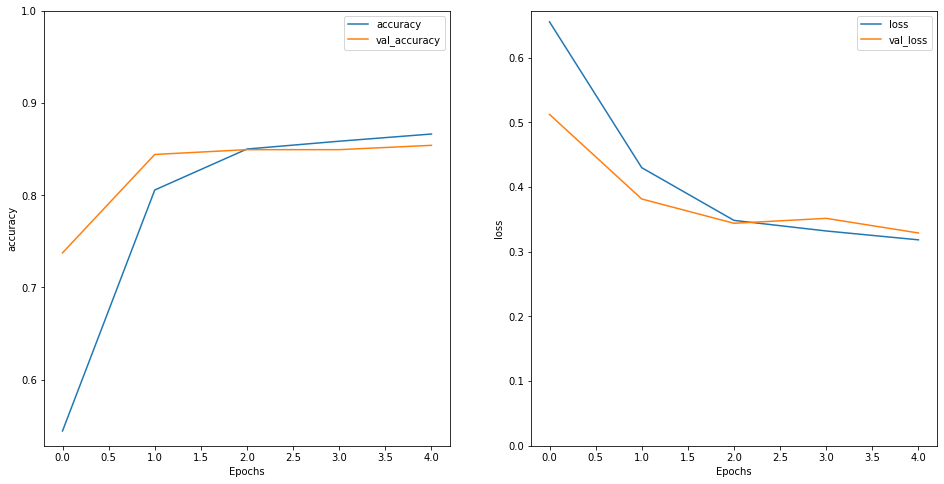

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**@title Try the model for prediction(enter the review below to see the sentiment of the review)**

In [19]:
review_text = "The movie was  good with the animation and the graphics" #@param {type:"string"}
#sample_text_1 = ('its not a good movie compared to previous one''would go for another watch')
predictions = model.predict(np.array([review_text]))
if predictions[0][0] > 0:
  print("The sentiment of the review is POSITIVE with polarity of : ",predictions[0][0])
else:
  print("The sentiment of the review is Negative with polarity of : ",predictions[0][0])

#print("The sentiment of the review is : ",predictions[0][0])

The sentiment of the review is POSITIVE with polarity of :  0.6742042
